In [29]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_compas, load_preproc_data_german

from aif360.algorithms.inprocessing.meta_fair_classifier import MetaFairClassifier
from aif360.algorithms.inprocessing.celisMeta.utils import getStats
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
display(Markdown("### Meta-Algorithm for fair classification."))
display(Markdown("The fairness metrics to be optimized have to specified as \"input\". Currently we can handle the following fairness metrics."))
display(Markdown("Statistical Rate, False Positive Rate, True Positive Rate, False Negative Rate, True Negative Rate,"))
display(Markdown("Accuracy Rate, False Discovery Rate, False Omission Rate, Positive Predictive Rate, Negative Predictive Rate."))
display(Markdown("#### -----------------------------"))
display(Markdown("The example below considers the case of False Discovery Parity."))


### Meta-Algorithm for fair classification.

The fairness metrics to be optimized have to specified as "input". Currently we can handle the following fairness metrics.

Statistical Rate, False Positive Rate, True Positive Rate, False Negative Rate, True Negative Rate,

Accuracy Rate, False Discovery Rate, False Omission Rate, Positive Predictive Rate, Negative Predictive Rate.

#### -----------------------------

The example below considers the case of False Discovery Parity.

In [31]:
dataset_orig = load_preproc_data_adult()

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)


In [32]:
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)


#### Training Dataset shape

(34189, 18)


#### Favorable and unfavorable labels

(1.0, 0.0)


#### Protected attribute names

['sex', 'race']


#### Privileged and unprivileged protected attribute values

([array([1.]), array([1.])], [array([0.]), array([0.])])


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


In [33]:
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)


#### Training Dataset shape

(34189, 18)


#### Favorable and unfavorable labels

(1.0, 0.0)


#### Protected attribute names

['sex', 'race']


#### Privileged and unprivileged protected attribute values

([array([1.]), array([1.])], [array([0.]), array([0.])])


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


In [34]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
#display(Markdown("#### Original training dataset"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())




min_max_scaler = MaxAbsScaler()
dataset_orig_train.features = min_max_scaler.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = min_max_scaler.transform(dataset_orig_test.features)
metric_scaled_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
#display(Markdown("#### Scaled dataset - Verify that the scaling does not affect the group label statistics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_train.mean_difference())
metric_scaled_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_test.mean_difference())


Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.193944
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.195913
Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.193944
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.195913


In [35]:
# Get classifier without fairness constraints
biased_model = MetaFairClassifier(tau=0, sensitive_attr="sex")
biased_model.fit(dataset_orig_train)

In [36]:
# Apply the unconstrained model to test data
dataset_bias_test = biased_model.predict(dataset_orig_test)

predictions = [1 if y == dataset_orig_train.favorable_label else -1 for y in list(dataset_bias_test.labels)]
y_test = np.array([1 if y == [dataset_orig_train.favorable_label] else -1 for y in dataset_orig_test.labels])
x_control_test = pd.DataFrame(data=dataset_orig_test.features, columns=dataset_orig_test.feature_names)["sex"]

acc, sr, unconstrainedFDR = getStats(y_test, predictions, x_control_test)
print(unconstrainedFDR)

('Accuracy : ', 3148, 14653, 0.7851634477581383)
('SR tau : ', 0.5128381178595508)
('FPR tau : ', 0.7945499159671334)
('FNR tau : ', 0.910501272336843)
('TPR tau : ', 0.7721613485851896)
('TNR tau : ', 0.986749402037707)
('AR tau : ', 0.8525978220135617)
('FDR tau : ', 0.5030017152658662)
('FOR tau : ', 0.3717552930362757)
('PPR tau : ', 0.5485001947798986)
('NPR tau : ', 0.827615343560593)
0.503001715266


In [37]:
# Learn debiased classifier
tau = 0.8
debiased_model = MetaFairClassifier(tau=tau, sensitive_attr="sex")
debiased_model.fit(dataset_orig_train)


('Training Accuracy: ', 0.7350317353534763, ', Training gamma: ', 0.672899406837947)


In [38]:
# Apply the debiased model to test data
dataset_debiasing_train = debiased_model.predict(dataset_orig_train)
dataset_debiasing_test = debiased_model.predict(dataset_orig_test)


In [39]:
# Metrics for the dataset from model with debiasing
display(Markdown("#### Model - with debiasing - dataset metrics"))
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(dataset_debiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_train.mean_difference())

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_test.mean_difference())


#### Model - with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.201319
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.195210


In [40]:
display(Markdown("#### Model - with debiasing - classification metrics"))
classified_metric_debiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_debiasing_test.accuracy())
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_debiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_debiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_debiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())


#### Model - with debiasing - classification metrics

Test set: Classification accuracy = 0.731932
Test set: Balanced classification accuracy = 0.716763
Test set: Disparate impact = 0.539856
Test set: Equal opportunity difference = -0.120467
Test set: Average odds difference = -0.117636
Test set: Theil_index = 0.128652


In [41]:
### Testing 
predictions = list(dataset_debiasing_test.labels)
predictions = [1 if y == dataset_orig_train.favorable_label else -1 for y in predictions]
y_test = np.array([1 if y == [dataset_orig_train.favorable_label] else -1 for y in dataset_orig_test.labels])
x_control_test = pd.DataFrame(data=dataset_orig_test.features, columns=dataset_orig_test.feature_names)["sex"]

acc, sr, fdr = getStats(y_test, predictions, x_control_test)
print(fdr, unconstrainedFDR)
assert(fdr >= unconstrainedFDR)

('Accuracy : ', 3928, 14653, 0.7319320275711458)
('SR tau : ', 0.5398556890759312)
('FPR tau : ', 0.6157226437750696)
('FNR tau : ', 0.7093999136230463)
('TPR tau : ', 0.8293479564733099)
('TNR tau : ', 0.8593163406441414)
('AR tau : ', 0.8892945217528149)
('FDR tau : ', 0.6832866118898019)
('FOR tau : ', 0.3834976405176844)
('PPR tau : ', 0.5596391928376183)
('NPR tau : ', 0.8967236467236467)
(0.6832866118898019, 0.5030017152658662)


In [ ]:
biased_model = MetaFairClassifier(tau=0, sensitive_attr="race")
biased_model.fit(dataset_orig_train)

dataset_bias_test = biased_model.predict(dataset_orig_test)

predictions = [1 if y == dataset_orig_train.favorable_label else -1 for y in list(dataset_bias_test.labels)]
y_test = np.array([1 if y == [dataset_orig_train.favorable_label] else -1 for y in dataset_orig_test.labels])
x_control_test = pd.DataFrame(data=dataset_orig_test.features, columns=dataset_orig_test.feature_names)["race"]

acc, sr, unconstrainedFDR = getStats(y_test, predictions, x_control_test)

In [10]:
display(Markdown("#### Running the algorithm for different tau values"))

accuracies, false_discovery_rates, statistical_rates = [], [], []
s_attr = "race"
# Converting to form used by celisMeta.utils file
y_test = np.array([1 if y == [dataset_orig_train.favorable_label] else -1 for y in dataset_orig_test.labels])
x_control_test = pd.DataFrame(data=dataset_orig_test.features, columns=dataset_orig_test.feature_names)[s_attr]

all_tau = np.linspace(0.1, 0.9, 9)
for tau in all_tau:
    print("Tau: %.2f" % tau)
    debiased_model = MetaFairClassifier(tau=tau, sensitive_attr=s_attr)
    debiased_model.fit(dataset_orig_train)
    
    dataset_debiasing_test = debiased_model.predict(dataset_orig_test)
    predictions = dataset_debiasing_test.labels
    predictions = [1 if y == dataset_orig_train.favorable_label else -1 for y in predictions]
    
    acc, sr, fdr = getStats(y_test, predictions, x_control_test)
    
    ## Testing
    assert (tau < unconstrainedFDR) or (fdr >= unconstrainedFDR)
    
    accuracies.append(acc)
    false_discovery_rates.append(fdr)
    statistical_rates.append(sr)
    

#### Running the algorithm for different tau values

Tau: 0.10
('Training Accuracy: ', 0.59007283044254, ', Training gamma: ', 0.8471557184765197)
('Accuracy : ', 6015, 14653, 0.5895038558656931)
('SR tau : ', 0.8607089248858592)
('FPR tau : ', 0.8957864358026685)
('FNR tau : ', 0.9194857234907978)
('TPR tau : ', 0.9919093179930415)
('TNR tau : ', 0.8974125546638897)
('AR tau : ', 0.9991230759162755)
('FDR tau : ', 0.8457246400235614)
('FOR tau : ', 0.5351545846135752)
('PPR tau : ', 0.6980432406212983)
('NPR tau : ', 0.972325603734294)
Tau: 0.20
('Training Accuracy: ', 0.7089122232296938, ', Training gamma: ', 0.8560547557579788)
('Accuracy : ', 4219, 14653, 0.7120726131167678)
('SR tau : ', 0.6866930102717664)
('FPR tau : ', 0.6726467708167688)
('FNR tau : ', 0.9258698009067614)
('TPR tau : ', 0.9788702965603217)
('TNR tau : ', 0.8609042092761701)
('AR tau : ', 0.9016318454549019)
('FDR tau : ', 0.8985716754370806)
('FOR tau : ', 0.5212835077229696)
('PPR tau : ', 0.8634340785883854)
('NPR tau : ', 0.9509873699572469)
Tau: 0.30
('Train

### Plot of accuracy and output fairness vs input constraint (tau)

#### Output fairness is represented by $\gamma_{fdr}$, which is the ratio of false discovery rate of different sensitive attribute values.

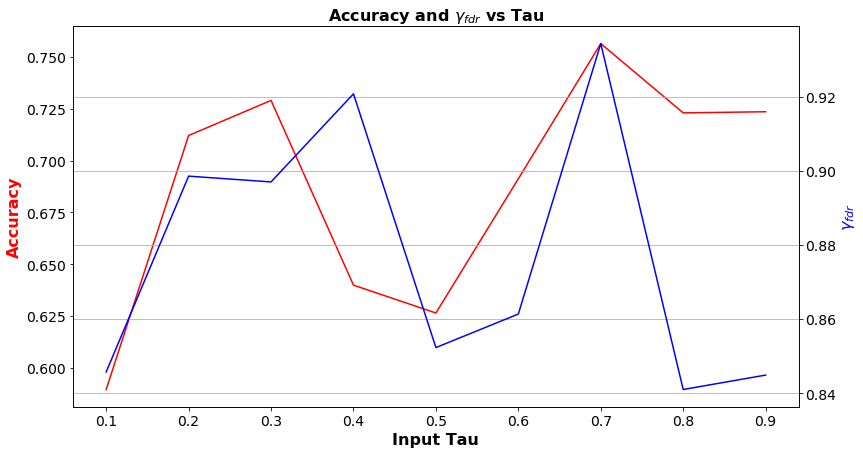

In [11]:
display(Markdown("### Plot of accuracy and output fairness vs input constraint (tau)"))

display(Markdown("#### Output fairness is represented by $\gamma_{fdr}$, which is the ratio of false discovery rate of different sensitive attribute values."))

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_tau, accuracies, color='r')
ax1.set_title('Accuracy and $\gamma_{fdr}$ vs Tau', fontsize=16, fontweight='bold')
ax1.set_xlabel('Input Tau', fontsize=16, fontweight='bold')
ax1.set_ylabel('Accuracy', color='r', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(all_tau, false_discovery_rates, color='b')
ax2.set_ylabel('$\gamma_{fdr}$', color='b', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)


In [ ]:
# # 
#     References:
#         Celis, L. E., Huang, L., Keswani, V., & Vishnoi, N. K. (2018). 
#         "Classification with Fairness Constraints: A Meta-Algorithm with Provable Guarantees.""
